##迴歸分析

[*********************100%***********************]  1 of 1 completed

Epoch 1/90


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 256451.8125 - mse: 256451.8125 - val_loss: 293937.7500 - val_mse: 293937.7500
Epoch 2/90
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 250269.5469 - mse: 250269.5469 - val_loss: 290337.0000 - val_mse: 290337.0000
Epoch 3/90
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 246954.7812 - mse: 246954.7812 - val_loss: 282558.1875 - val_mse: 282558.1875
Epoch 4/90
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 236225.7344 - mse: 236225.7344 - val_loss: 268432.0312 - val_mse: 268432.0312
Epoch 5/90
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 211518.2656 - mse: 211518.2656 - val_loss: 246027.2031 - val_mse: 246027.2031
Epoch 6/90
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 184101.7812 - mse: 184101.7812 - val_loss: 216037.5156 - val_mse: 216037.5156
Epoch 7/90
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 143319.0625 - mse: 143319.0625 - val_loss: 180171.2812 - val_mse: 180171.2812
Epoch 8/90
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

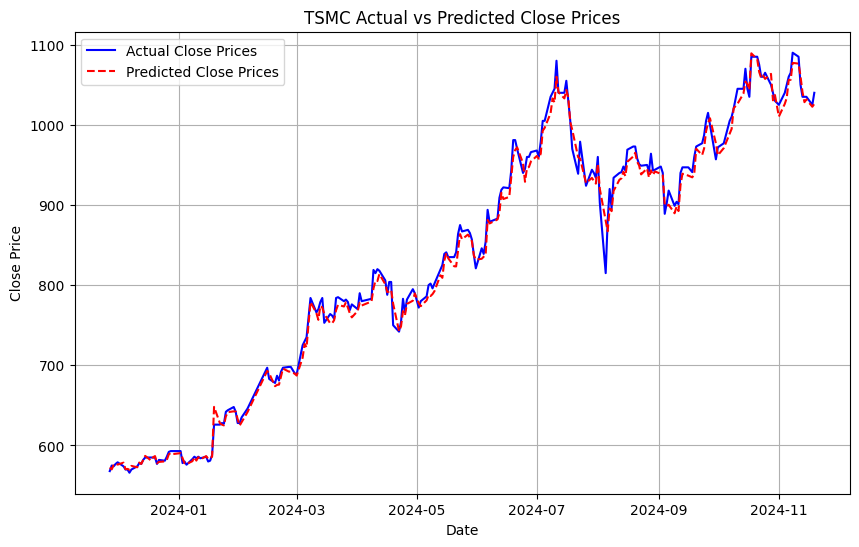

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Close Price for the Next Trading Day: 1027.53


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:745: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


In [16]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

def get_yahoo_finance_data(symbol, start, end):
    df = yf.download(symbol, start=start, end=end)
    if 'Close' not in df.columns:
        raise Exception("Failed to fetch Close price data")
    return df

start = "2020-01-01"
end = "2024-11-20"

try:
    df_2330 = get_yahoo_finance_data('2330.TW', start, end)

    # 構建滯後特徵
    df_2330['Lag_1'] = df_2330['Close'].shift(1)
    df_2330['Lag_2'] = df_2330['Close'].shift(2)

    # 移除前兩天無效數據(NaN)，並確保數據完整性
    df_2330 = df_2330.dropna()

    # X:自變數, Y:應變數
    X = df_2330[['Open', 'High', 'Low', 'Volume', 'Lag_1', 'Lag_2']]
    y = df_2330['Close']

    # 切分數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 標準化數據
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # 建立神經網路模型
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(units=459, kernel_initializer="glorot_normal", activation="relu"))
    model.add(Dense(units=9, kernel_initializer="glorot_normal", activation="relu"))
    model.add(Dense(units=1, kernel_initializer="glorot_normal", activation="linear"))

    # 編譯模型
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    # 訓練模型
    history = model.fit(X_train, y_train, epochs=90, batch_size=32, validation_split=0.2, verbose=1)

    # 預測
    y_pred = model.predict(X_test)

    # 評估模型表現
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse:.4f}')

    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label="Actual Close Prices", color='blue')
    plt.plot(y_test.index, y_pred, label="Predicted Close Prices", color='red', linestyle='dashed')
    plt.title("TSMC Actual vs Predicted Close Prices")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()

    # 預測下一個交易日
    last_row = df_2330.iloc[-1]
    next_input = pd.DataFrame({
        'Open': [last_row['Open']],
        'High': [last_row['High']],
        'Low': [last_row['Low']],
        'Volume': [last_row['Volume']],
        'Lag_1': [last_row['Close']],
        'Lag_2': [df_2330.iloc[-2]['Close']]
    })

    # 標準化
    next_input_scaled = scaler.transform(next_input)

    # 預測下一個交易日收盤價
    next_pred = model.predict(next_input_scaled)
    print(f"Predicted Close Price for the Next Trading Day: {next_pred[0][0]:.2f}")

except Exception as e:
    print(e)

##模型校正

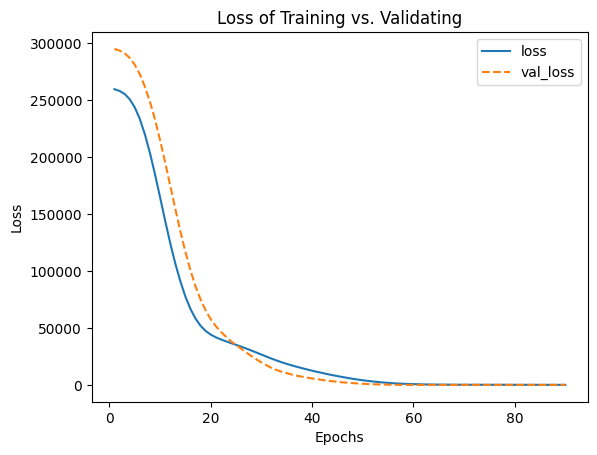

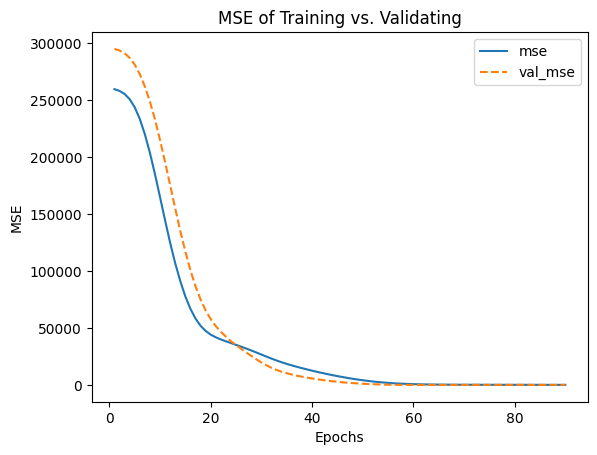

In [19]:
import os

if not os.path.isdir("HappyML"):
  os.system("git clone https://github.com/cnchi/HappyML.git")

# Model Adjustment
import HappyML.model_drawer as md

md.epochs_metrics_plot(epochs_metrics.history, keys=("loss", "val_loss"), title="Loss of Training vs. Validating", xyLabel=("Epochs", "Loss"))
md.epochs_metrics_plot(epochs_metrics.history, keys=("mse", "val_mse"), title="MSE of Training vs. Validating", xyLabel=("Epochs", "MSE"))